# Part 1: Heterogeneous treatment effects using causal trees and forests

For this part, we will be using experimental data for computing heterogeneous effects through causal trees and forests. For all exercises, the predictors X are all variables that are not the outcome Y or the treatment D.

1.1. Load the data (1 points). This is data for and experiment regarding the National Supported Work Demonstration (NSW) job-training program. You can find the data here, and read a description of the data here. For further details of the experiment and the program, you can use this link

In [49]:
using CSV
using DataFrames  

url = "https://raw.githubusercontent.com/d2cml-ai/CausalAI-Course/main/Labs/Assignment/Assignment_5/data/experimental/experimental_control.csv"
df = CSV.read(download(url), DataFrame)

first(df, 5)

Row,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64,Float64
1,1,37,11,1,0,1,1,0.0,0.0,9930.05
2,1,22,9,0,1,0,1,0.0,0.0,3595.89
3,1,30,12,1,0,0,0,0.0,0.0,24909.4
4,1,27,11,1,0,0,1,0.0,0.0,7506.15
5,1,33,8,1,0,0,1,0.0,0.0,289.79


In [50]:
using Pkg
Pkg.add("ScientificTypes")  
using ScientificTypes  

   Resolving package versions...
  No Changes to `C:\Users\KARL\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\KARL\.julia\environments\v1.11\Manifest.toml`


In [51]:

summary_table = DataFrame(
    names = names(df),
    scitypes = scitype.(eachcol(df)),  
    types = eltype.(eachcol(df))       

)


Row,names,scitypes,types
,String,DataType,DataType
1,treat,AbstractVector{Count},Int64
2,age,AbstractVector{Count},Int64
3,educ,AbstractVector{Count},Int64
4,black,AbstractVector{Count},Int64
5,hisp,AbstractVector{Count},Int64
6,marr,AbstractVector{Count},Int64
7,nodegree,AbstractVector{Count},Int64
8,re74,AbstractVector{Continuous},Float64
9,re75,AbstractVector{Continuous},Float64


1.2. Find the ATE (1.5 points). With re78 as the outcome variable of interest, find the Average Treatment Effect of participation in the program. Specifically, you should find it by calculating the difference between the means of the treatment group and the control group (the Simple Difference of Means or SDM). What can you say about the program?

In [52]:
# First method
using Statistics 

mean_treat = mean(df[df.treat .== 1, :re78])
mean_control = mean(df[df.treat .== 0, :re78])

# Calcular el ATE
ATE = mean_treat - mean_control

println("El Average Treatment Effect (ATE) es: $ATE")

El Average Treatment Effect (ATE) es: 1794.3423818501024


In [53]:
# Second method
using GLM

model = lm(@formula(re78 ~ treat), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

re78 ~ 1 + treat

Coefficients:
───────────────────────────────────────────────────────────────────────
               Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────
(Intercept)  4554.8      408.046  11.16    <1e-24   3752.85     5356.75
treat        1794.34     632.853   2.84    0.0048    550.574    3038.11
───────────────────────────────────────────────────────────────────────

The program had a positive impact on the participants' income, increasing their earnings by an average of 1794.34 monetary units compared to the control group. It can be concluded that the program is effective in improving participants' income.

1.3. Heterogeneous effects with causal trees (3 points). Use causal trees like we saw in class. For Python, you should use the econml package; for R, use the grf package; and for Julia, you will need to create the auxiliary variable 
Y∗ and fit a decision tree regressor. Report the splits the tree finds and interpret them.

Utiliza árboles causales como se explicó en clase. Para Python, deberías usar el paquete econml; para R, utiliza el paquete grf; y para Julia, necesitarás crear la variable auxiliar 𝑌∗Y ∗  y ajustar un árbol de decisión regresor. Reporta las divisiones que los árboles encuentran e interpreta los resultados.

In [54]:
using Pkg
Pkg.add("MLJ")
Pkg.add("MLJModels")
Pkg.add("RDatasets")
Pkg.add("MLJScikitLearnInterface")

   Resolving package versions...
  No Changes to `C:\Users\KARL\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\KARL\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\KARL\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\KARL\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\KARL\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\KARL\.julia\environments\v1.11\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\KARL\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\KARL\.julia\environments\v1.11\Manifest.toml`


In [56]:
using MLJ, MLJModels, RDatasets

coerce!(df, 
    :age => Continuous,  
    :educ => Continuous,
)

coerce!(df, Count => Multiclass)

y, X = unpack(df, ==(:re78), !=(:re78));
coerce!(X, Count => Multiclass)

D, X = unpack(X, ==(:treat), !=(:treat));

In [57]:
onehotencoder = @load OneHotEncoder pkg=MLJModels verbosity=0

ohe = onehotencoder(features = [:black,:hisp,:marr,:nodegree])
ohe_machine = machine(ohe, X)
fit!(ohe_machine);
X = MLJ.transform(ohe_machine, X);

[ Info: Training machine(OneHotEncoder(features = [:black, :hisp, :marr, :nodegree], …), …).
[ Info: Spawning 2 sub-features to one-hot encode feature :black.
[ Info: Spawning 2 sub-features to one-hot encode feature :hisp.
[ Info: Spawning 2 sub-features to one-hot encode feature :marr.
[ Info: Spawning 2 sub-features to one-hot encode feature :nodegree.


In [58]:
summary_table = DataFrame(
    names = names(df),
    scitypes = scitype.(eachcol(df)),  
    types = eltype.(eachcol(df))       

)


Row,names,scitypes,types
,String,DataType,DataType
1,treat,AbstractVector{Multiclass{2}},"CategoricalValue{Int64, UInt32}"
2,age,AbstractVector{Continuous},Float64
3,educ,AbstractVector{Continuous},Float64
4,black,AbstractVector{Multiclass{2}},"CategoricalValue{Int64, UInt32}"
5,hisp,AbstractVector{Multiclass{2}},"CategoricalValue{Int64, UInt32}"
6,marr,AbstractVector{Multiclass{2}},"CategoricalValue{Int64, UInt32}"
7,nodegree,AbstractVector{Multiclass{2}},"CategoricalValue{Int64, UInt32}"
8,re74,AbstractVector{Continuous},Float64
9,re75,AbstractVector{Continuous},Float64


In [59]:
LogisticClassifier = @load LogisticClassifier pkg=MLJScikitLearnInterface verbosity=0

log_model = LogisticClassifier()

log_model_machine = machine(log_model, X, D)

fit!(log_model_machine)

[ Info: Training machine(LogisticClassifier(penalty = l2, …), …).
C:\Users\KARL\.julia\environments\v1.11\.CondaPkg\env\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\KARL\.julia\environments\v1.11\.CondaPkg\env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


trained Machine; caches model-specific representations of data
  model: LogisticClassifier(penalty = l2, …)
  args: 
    1:	Source @899 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @403 ⏎ AbstractVector{Multiclass{2}}


In [61]:
coerce!(df, :treat => Count)

pscore = pdf.(MLJ.predict(log_model_machine, X),1)
y_star = df.re78./ (df.treat .* pscore .- (1 .- df.treat) .* (1 .- pscore));

In [63]:
using Pkg
Pkg.add("MLJDecisionTreeInterface")

   Resolving package versions...
   Installed ScikitLearnBase ────────── v0.5.0
   Installed AbstractTrees ──────────── v0.4.5
   Installed MLJDecisionTreeInterface ─ v0.4.2
   Installed DecisionTree ───────────── v0.12.4
    Updating `C:\Users\KARL\.julia\environments\v1.11\Project.toml`
  [c6f25543] + MLJDecisionTreeInterface v0.4.2
    Updating `C:\Users\KARL\.julia\environments\v1.11\Manifest.toml`
  [1520ce14] + AbstractTrees v0.4.5
  [7806a523] + DecisionTree v0.12.4
  [c6f25543] + MLJDecisionTreeInterface v0.4.2
  [6e75b9c4] + ScikitLearnBase v0.5.0
Precompiling project...
   3352.5 ms  ✓ AbstractTrees
   2211.5 ms  ✓ ScikitLearnBase
   2068.8 ms  ✓ DecisionTree
   2818.0 ms  ✓ MLJDecisionTreeInterface
  4 dependencies successfully precompiled in 10 seconds. 401 already precompiled.


In [67]:
X = select!(X, Not(:black__0, :hisp__0, :marr__0, :nodegree__0));

In [68]:
forest_model = RandomForestRegressor(n_trees = 100)
forest_machine = machine(forest_model, X, y_star)
fit!(forest_machine);

[ Info: Training machine(RandomForestRegressor(max_depth = -1, …), …).


In [70]:
fitted_forest = fitted_params(forest_machine)

(forest = Ensemble of Decision Trees
Trees:      100
Avg Leaves: 174.53
Avg Depth:  18.82,)

The forest consists of 100 decision trees (default value). On average, each tree has approximately 174.53 leaves, and its average depth reaches 18.82 levels.

1.4. Heterogeneous effects with causal forests (3 points). Use causal forests like we saw in class. For Python, you should use the econml package; for R, use the grf package; and for Julia, you will need to use the auxiliary variable Y∗ computed in the previous exercise and fit a random forest regressor. Report the importance of the prediction variables.

In [71]:
feature_importances(forest_machine)

8-element Vector{Pair{Symbol, Float64}}:
         :age => 0.3108334995673283
        :re74 => 0.23504385459407331
        :re75 => 0.20351408601314336
        :educ => 0.13293173259217456
    :black__1 => 0.03938920370651372
     :marr__1 => 0.03859921629377362
     :hisp__1 => 0.023855838991200553
 :nodegree__1 => 0.015832568241792636

In [72]:
importances = DataFrame(feature_importances(forest_machine))
importances = DataFrame(variables = names(importances), importance = collect(values(importances[1, :])))

Row,variables,importance
,String,Float64
1,age,0.310833
2,re74,0.235044
3,re75,0.203514
4,educ,0.132932
5,black__1,0.0393892
6,marr__1,0.0385992
7,hisp__1,0.0238558
8,nodegree__1,0.0158326


The variable age is the most important as it contributes approximately 31.08% to the predictive capacity of the model.

1.5. Plot heterogeneous effects (1.5 points). Plot how the predicted treatment effect changes depending on a variable of your choice. (You can see the last example in PD11 for clarification of what you should do in this exercise)

In [84]:
df[:, "effect"] = 7 * exp.(-(df.age.- 18) .^2 ./100) + 3*(df.treat.==1) - 2*(df.black.==0) + (df.hisp.==1) .- 2.5;
df[df[:, "effect"] .< 0, "effect"] .= 0;

In [85]:
df.age_bins = round.(df.age .* 2) ./ 2
effect_bins = combine(groupby(df, :age_bins), :effect => mean => :mean_effect)

Row,age_bins,mean_effect
,Float64,Float64
1,17.0,5.98917
2,18.0,6.29487
3,19.0,5.9758
4,20.0,5.93386
5,21.0,5.05541
6,22.0,4.83538
7,23.0,4.35901
8,24.0,3.96707
9,25.0,3.29897


In [81]:
import Pkg
Pkg.add("StatsPlots")

   Resolving package versions...
   Installed MultivariateStats ─ v0.10.3
   Installed KernelDensity ───── v0.6.9
   Installed OffsetArrays ────── v1.14.1
   Installed Ratios ──────────── v0.4.5
   Installed StatsPlots ──────── v0.15.7
   Installed NearestNeighbors ── v0.4.21
   Installed Interpolations ──── v0.15.1
   Installed AxisAlgorithms ──── v1.1.0
   Installed Arpack_jll ──────── v3.5.1+1
   Installed TableOperations ─── v1.2.0
   Installed Widgets ─────────── v0.6.7
   Installed Observables ─────── v0.5.5
   Installed Arpack ──────────── v0.5.4
   Installed WoodburyMatrices ── v1.0.0
   Installed Clustering ──────── v0.15.7
    Updating `C:\Users\KARL\.julia\environments\v1.11\Project.toml`
  [f3b207a7] + StatsPlots v0.15.7
    Updating `C:\Users\KARL\.julia\environments\v1.11\Manifest.toml`
  [7d9fca2a] + Arpack v0.5.4
  [13072b0f] + AxisAlgorithms v1.1.0
  [aaaa29a8] + Clustering v0.15.7
  [a98d9a8b] + Interpolations v0.15.1
  [5ab0869b] + KernelDensity v0.6.9
  [6f286f6a] +

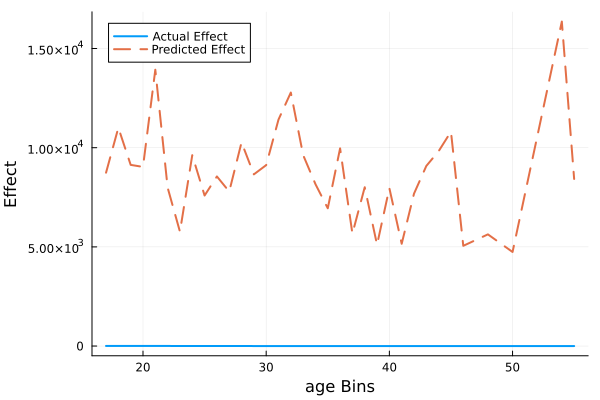

In [86]:
# using CategoricalArrays
using StatsPlots

predicted = MLJ.predict(forest_machine, X);
df.predicted_effect = predicted
predicted_effect_bins = combine(groupby(df, :age_bins), :predicted_effect => mean => :mean_predicted_effect);
df.age_bins = floor.(df.age .* 2) ./ 2

effect_bins = combine(groupby(df, :age_bins), :effect => mean => :mean_effect)
sort!(effect_bins, :age_bins)

df.predicted_effect =  predicted

predicted_effect_bins = combine(groupby(df, :age_bins), :predicted_effect => mean => :mean_predicted_effect)
sort!(predicted_effect_bins, :age_bins)

plot(effect_bins.age_bins, effect_bins.mean_effect, label="Actual Effect", xlabel="age Bins", ylabel="Effect", lw=2)
plot!(predicted_effect_bins.age_bins, predicted_effect_bins.mean_predicted_effect, label="Predicted Effect", lw=2, linestyle=:dash)

# Part 2: Double/Debiased machine learning in observational data

In this part, we will be using observational data for computing the average treatment effect of the same program as in Part 1. This data is constructed by taking the treatment group from the same dataset as in Part 1, but constructing the control group from a different dataset; that is, the entirety of the control is comprised of observations from the Current Population Survey. Therefor, we may not have comparable treatment and control groups. To tackle this issue, we can use Double/Debiased machine learning.

2.1. Load the data (1 points). You can find the data here, and read a description of the data here. For further details on how this data was created, you can use this link.

2.2. Group comparisons (1.5 points). For the treatment and control group separately, report summary statistics of three variables of your choice. Can you spot any big differences between the treatment and control groups?

2.3. Compute the SMD (1.5 points). Find the simple difference of means, which we can use as a naive estimate of the ATE. How does the result in this case compare to the result in point 1.2.?

2.4. Using DML (6 points). Use the DML procedure as we saw in the Lab, in order to find a better estimate of the ATE. You may use the doubleML packages for Python and R, but this package does not exist for Julia, so you will have to build your own procedure like we saw in class. You will be rewarded extra points for using more than one method for predictions. At the end, report the treatment effect you found, as well as the MSE for D and Y achieved by the method(s) you used.